# DoWhy:一个简单例子


这是DoWhy因果推理库的快速介绍。我们将 load in a sample dataset，并估计the causal effect of a (pre-specified)treatment variable on a (pre-specified) outcome variable.

首先，让我们为Python添加所需的路径以找到DoWhy代码并加载所有必需的软件包。

<img src="http://imgcdn.atyun.com/2019/06/3-7.png" width=400 /></a>


In [5]:
import os, sys
sys.path.append(os.path.abspath("../../../"))

# Let's check the python version. 
print(sys.version)

3.7.4 (default, Aug 13 2019, 15:17:50) 
[Clang 4.0.1 (tags/RELEASE_401/final)]


In [3]:
import numpy as np
import pandas as pd

import dowhy
from dowhy import CausalModel
import dowhy.datasets 

现在，让我们加载一个数据集。为简单起见，我们模拟了一个数据集，该数据集具有 linear relationships between common causes and treatment, and common causes and outcome. 

Beta是真正的因果效应。

In [7]:
data = dowhy.datasets.linear_dataset(beta=10,
        num_common_causes=5,
        num_instruments = 2,
        num_effect_modifiers=1,
        num_samples=10000, 
        treatment_is_binary=True)
df = data["df"]
print(df.head())
print(data["dot_graph"])
print("\n")
print(data["gml_graph"])

         X0   Z0        Z1        W0        W1        W2        W3        W4  \
0  0.298611  1.0  0.472086  1.968652  0.008722  1.085433 -0.999968  1.389409   
1 -0.048842  1.0  0.584457  2.898602 -0.904939 -0.745294 -0.980058  0.969095   
2 -0.123133  1.0  0.138142 -0.802696 -0.790802  1.029180  0.010684 -0.205064   
3 -0.248771  0.0  0.098777  1.297670 -1.027000  0.792586  1.247469 -0.007736   
4 -0.583826  1.0  0.924724 -1.341020 -1.295737 -0.612708 -2.955439 -0.674400   

      v0          y  
0   True   9.440576  
1   True   7.356542  
2   True  10.143119  
3   True  17.301749  
4  False -15.930469  
digraph { U[label="Unobserved Confounders"]; U->y;v0->y; U->v0;W0-> v0; W1-> v0; W2-> v0; W3-> v0; W4-> v0;Z0-> v0; Z1-> v0;W0-> y; W1-> y; W2-> y; W3-> y; W4-> y;X0-> y;}


graph[directed 1node[ id "y" label "y"]node[ id "Unobserved Confounders" label "Unobserved Confounders"]edge[source "Unobserved Confounders" target "y"]node[ id "W0" label "W0"] node[ id "W1" label "W1"] node[ id 

Note that we are using a pandas dataframe to load the data. 目前，DoWhy 仅支持 pandas 数据框作为输入。

## 建立因果模型

有两种方式来指定因果模型中的因果图，包括直接输入因果图和指定 Common causes and IVs。

### Interface 1: 输入因果图(recommended)

现在，我们以GML图格式输入因果图（推荐）。您也可以使用DOT格式。

In [14]:
# With graph
model=CausalModel(
        data = df,
        treatment=data["treatment_name"],
        outcome=data["outcome_name"],
        graph=data["gml_graph"],
        proceed_when_unidentifiable=True
        )

INFO:dowhy.causal_model:Model to find the causal effect of treatment ['v0'] on outcome ['y']


In [15]:
model.view_model()

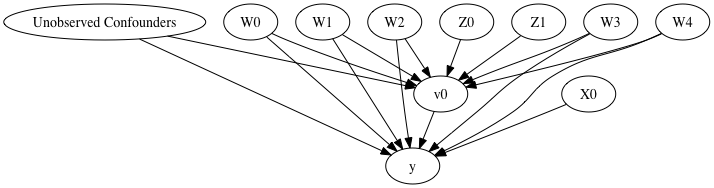

In [16]:
from IPython.display import Image, display
display(Image(filename="causal_model.png"))

上面的因果图显示了因果模型中编码的因果关系假设。现在，我们可以使用此图首先 identify 因果效应 (go from a causal estimand to a probability expression)，然后估计因果效应。

**DoWhy 的哲学: 把识别和估计分开**

Identification 问题仅仅需要直到因果图，而不需要直到数据就可以回答。 This results in an expression to be computed. This expression can then be evaluated using the available data in the estimation step. 把 Identification 和 Estimation 分开是一件重要的事情。

* Identification

In [17]:
identified_estimand = model.identify_effect()
print(identified_estimand)

INFO:dowhy.causal_identifier:Common causes of treatment and outcome:['W3', 'Unobserved Confounders', 'W1', 'W4', 'W2', 'W0']
INFO:dowhy.causal_identifier:Continuing by ignoring these unobserved confounders because proceed_when_unidentifiable flag is True.
INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:['Z1', 'Z0']


Estimand type: nonparametric-ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                 
─────(Expectation(y|W3,W1,W4,W2,W0))
d[v₀]                               
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W3,W1,W4,W2,W0,U) = P(y|v0,W3,W1,W4,W2,W0)
### Estimand : 2
Estimand name: iv
Estimand expression:
Expectation(Derivative(y, [Z1, Z0])*Derivative([v0], [Z1, Z0])**(-1))
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z1,Z0})
Estimand assumption 2, Exclusion: If we remove {Z1,Z0}→{v0}, then ¬({Z1,Z0}→y)



If you want to disable the warning for ignoring unobserved confounders, you can add a parameter flag ( *proceed\_when\_unidentifiable* ). The same parameter can also be added when instantiating the CausalModel object. 

In [20]:
# identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
# print(identified_estimand)

* Estimation

In [21]:
causal_estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.propensity_score_stratification")
print(causal_estimate)
print("Causal Estimate is " + str(causal_estimate.value))

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Stratification Estimator
INFO:dowhy.causal_estimator:b: y~v0+W3+W1+W4+W2+W0
/Users/gong/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/gong/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
INFO:numexpr.utils:NumExpr defaulting to 4 threads.


*** Causal Estimate ***

## Target estimand
Estimand type: nonparametric-ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                 
─────(Expectation(y|W3,W1,W4,W2,W0))
d[v₀]                               
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W3,W1,W4,W2,W0,U) = P(y|v0,W3,W1,W4,W2,W0)
### Estimand : 2
Estimand name: iv
Estimand expression:
Expectation(Derivative(y, [Z1, Z0])*Derivative([v0], [Z1, Z0])**(-1))
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z1,Z0})
Estimand assumption 2, Exclusion: If we remove {Z1,Z0}→{v0}, then ¬({Z1,Z0}→y)

## Realized estimand
b: y~v0+W3+W1+W4+W2+W0
## Estimate
Value: 10.792276505186594

Causal Estimate is 10.792276505186594


您可以将额外参数输入到 estimate_effect 方法中。 例如, to estimate the effect on any subset of the units, you can specify the "target_units" parameter which can be a string ("ate", "att", or "atc"), lambda function that filters rows of the data frame, or a new dataframe on which to compute the effect. 您还可以指定 "effect modifiers" 来估计  heterogeneous effects across these variables. See `help(CausalModel.estimate_effect)`.

In [22]:
# Causal effect on the control group (ATC)
causal_estimate_att = model.estimate_effect(identified_estimand,
        method_name="backdoor.propensity_score_stratification",
        target_units = "atc")
print(causal_estimate_att)
print("Causal Estimate is " + str(causal_estimate_att.value))

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Stratification Estimator
INFO:dowhy.causal_estimator:b: y~v0+W3+W1+W4+W2+W0


*** Causal Estimate ***

## Target estimand
Estimand type: nonparametric-ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                 
─────(Expectation(y|W3,W1,W4,W2,W0))
d[v₀]                               
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W3,W1,W4,W2,W0,U) = P(y|v0,W3,W1,W4,W2,W0)
### Estimand : 2
Estimand name: iv
Estimand expression:
Expectation(Derivative(y, [Z1, Z0])*Derivative([v0], [Z1, Z0])**(-1))
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z1,Z0})
Estimand assumption 2, Exclusion: If we remove {Z1,Z0}→{v0}, then ¬({Z1,Z0}→y)

## Realized estimand
b: y~v0+W3+W1+W4+W2+W0
## Estimate
Value: 10.86506021561111

Causal Estimate is 10.86506021561111


/Users/gong/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/gong/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### Interface 2: 指定共同原因和工具变量

另外一种建立因果模型的办法是指定共同原因和工具变量，DoWhy 会把其他协变量自动理解成 Confounders.

In [23]:
# Without graph                                       
model= CausalModel(                             
        data=df,                                      
        treatment=data["treatment_name"],             
        outcome=data["outcome_name"],                 
        common_causes=data["common_causes_names"],
        effect_modifiers=data["effect_modifier_names"],
        proceed_when_unidentifiable=True)                         

INFO:dowhy.causal_graph:If this is observed data (not from a randomized experiment), there might always be missing confounders. Adding a node named "Unobserved Confounders" to reflect this.
INFO:dowhy.causal_model:Model to find the causal effect of treatment ['v0'] on outcome ['y']


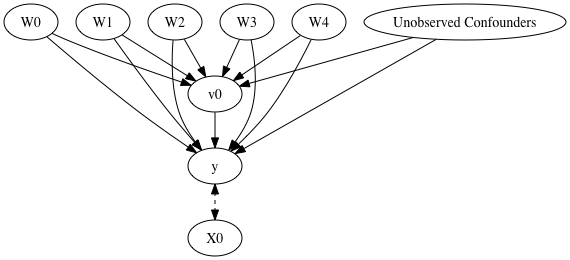

In [26]:
model.view_model()

from IPython.display import Image, display
display(Image(filename="causal_model.png"))

我们得到相同的因果图。Now identification and estimation is done as before.

In [27]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)                         

INFO:dowhy.causal_identifier:Common causes of treatment and outcome:['U', 'W3', 'W1', 'W4', 'W2', 'W0']
INFO:dowhy.causal_identifier:Continuing by ignoring these unobserved confounders because proceed_when_unidentifiable flag is True.
INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]


* Estimation

In [28]:
estimate = model.estimate_effect(identified_estimand,
                                 method_name="backdoor.propensity_score_stratification")         
print(estimate)
print("Causal Estimate is " + str(estimate.value))

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Stratification Estimator
INFO:dowhy.causal_estimator:b: y~v0+W3+W1+W4+W2+W0


*** Causal Estimate ***

## Target estimand
Estimand type: nonparametric-ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                 
─────(Expectation(y|W3,W1,W4,W2,W0))
d[v₀]                               
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W3,W1,W4,W2,W0,U) = P(y|v0,W3,W1,W4,W2,W0)
### Estimand : 2
Estimand name: iv
No such variable found!

## Realized estimand
b: y~v0+W3+W1+W4+W2+W0
## Estimate
Value: 10.792276505186594

Causal Estimate is 10.792276505186594


/Users/gong/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/gong/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## 稳健性分析

我们通过多种方法来 Refuting the estimate obtained.



### Adding a random common cause variable

增加一个随机的公共原因之后，因果效应应该变化不大。

In [29]:
res_random=model.refute_estimate(identified_estimand, estimate, method_name="random_common_cause")
print(res_random)

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Stratification Estimator
INFO:dowhy.causal_estimator:b: y~v0+W3+W1+W4+W2+W0+w_random


Refute: Add a Random Common Cause
Estimated effect:(10.792276505186594,)
New effect:(10.782778434172412,)



/Users/gong/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/gong/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### Adding an unobserved common cause variable



In [30]:
res_unobserved=model.refute_estimate(identified_estimand, estimate, method_name="add_unobserved_common_cause",
                                     confounders_effect_on_treatment="binary_flip", confounders_effect_on_outcome="linear",
                                    effect_strength_on_treatment=0.01, effect_strength_on_outcome=0.02)
print(res_unobserved)

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Stratification Estimator
INFO:dowhy.causal_estimator:b: y~v0+W3+W1+W4+W2+W0


Refute: Add an Unobserved Common Cause
Estimated effect:(10.792276505186594,)
New effect:(10.129153493116183,)



/Users/gong/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/gong/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### Replacing treatment with a random (placebo) variable

  用随机的变量来替代 treatment 之后，因果效应应该接近于零。

In [31]:
res_placebo=model.refute_estimate(identified_estimand, estimate,
        method_name="placebo_treatment_refuter", placebo_type="permute")
print(res_placebo)

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Stratification Estimator
INFO:dowhy.causal_estimator:b: y~placebo+W3+W1+W4+W2+W0


Refute: Use a Placebo Treatment
Estimated effect:(10.792276505186594,)
New effect:(-0.16129739849906674,)



/Users/gong/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/gong/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### Removing a random subset of the data

随机去掉部分数据之后，因果效应应该差别不大。

In [33]:
res_subset=model.refute_estimate(identified_estimand, estimate,
        method_name="data_subset_refuter", subset_fraction=0.9)
print(res_subset)


INFO:dowhy.causal_estimator:INFO: Using Propensity Score Stratification Estimator
INFO:dowhy.causal_estimator:b: y~v0+W3+W1+W4+W2+W0


Refute: Use a subset of data
Estimated effect:(10.792276505186594,)
New effect:(10.74248108326355,)



/Users/gong/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/gong/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


如您所见，propensity score stratification estimator 对于反驳具有相当强的鲁棒性。为了重现性，您可以向任何反驳方法中添加参数“ random_seed”，如下所示。


In [34]:
res_subset=model.refute_estimate(identified_estimand, estimate,
        method_name="data_subset_refuter", subset_fraction=0.9, random_seed = 1)
print(res_subset)

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Stratification Estimator
INFO:dowhy.causal_estimator:b: y~v0+W3+W1+W4+W2+W0
/Users/gong/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/gong/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Refute: Use a subset of data
Estimated effect:(10.792276505186594,)
New effect:(10.787402005825863,)

